**Import Libraries**

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.2MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

In [ ]:
df = pd.read_csv("SeoulBikeData.csv", encoding= 'unicode_escape')

**Preprocessing**



In [ ]:
df.replace("?",np.NaN,inplace = True)
df

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [ ]:
df.isnull().values.any()

False

**One hot encoding for multivalue categorical variable Seasons**

In [ ]:
df['Seasons'].unique()

array(['Winter', 'Spring', 'Summer', 'Autumn'], dtype=object)

In [ ]:
dummies = pd.get_dummies(df['Seasons'])
dummies

,Autumn,Spring,Summer,Winter
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
8755,1,0,0,0
8756,1,0,0,0
8757,1,0,0,0
8758,1,0,0,0


In [ ]:
df = pd.concat([df,dummies], axis = 1)

In [ ]:
df.drop(['Seasons'],axis = 1,inplace = True)

**Encode binary categoricals variables (Holiday and Functioning Day)**


In [ ]:
print(df['Holiday'].unique())
print(df['Functioning Day'].unique())

['No Holiday' 'Holiday']
['Yes' 'No']


In [ ]:
df['Holiday'].replace(('No Holiday','Holiday'),(0,1),inplace = True)
df['Functioning Day'].replace(('No','Yes'),(0,1),inplace = True)

**Dropping Date variable because it is not usable for algorithm and the dataset already has variables seasons,holiday,functioning day which can represent the information of the year**

In [ ]:
df.drop(['Date'],axis = 1,inplace = True)

**Handling cyclic feature Hours, in this case from 0 to 23 i represent them with unit circle**

In [ ]:
Hour_sin = np.sin(df['Hour']*(2.*np.pi/24))
Hour_cos = np.cos(df['Hour']*(2.*np.pi/24))

In [ ]:
Hour_sin_df = pd.DataFrame(Hour_sin)
Hour_cos_df = pd.DataFrame(Hour_cos)
Hour_sin_df.rename(columns={"Hour": "Hour sin"},inplace = True)
Hour_cos_df.rename(columns={"Hour": "Hour cos"},inplace = True)

In [ ]:
df_Hour_Cyclic = df.copy()
df_Hour_Cyclic = pd.concat((df_Hour_Cyclic,Hour_sin_df),axis = 1)
df_Hour_Cyclic = pd.concat((df_Hour_Cyclic,Hour_cos_df),axis = 1)
df_Hour_Cyclic.drop(['Hour'],axis = 1,inplace = True)

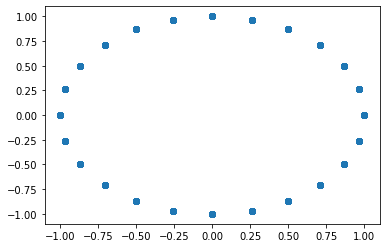

In [ ]:
plt.scatter(df_Hour_Cyclic['Hour cos'],df_Hour_Cyclic['Hour sin'])

**Print statistical values for variables and how we can see there is a big difference between means, so its good idea to apply normalization on data**

In [ ]:
df_Hour_Cyclic.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,7.046021e+02,644.997468,0.0,191.000000,5.045000e+02,1065.250000,3556.00
Temperature(°C),8760.0,1.288292e+01,11.944825,-17.8,3.500000,1.370000e+01,22.500000,39.40
Humidity(%),8760.0,5.822626e+01,20.362413,0.0,42.000000,5.700000e+01,74.000000,98.00
Wind speed (m/s),8760.0,1.724909e+00,1.036300,0.0,0.900000,1.500000e+00,2.300000,7.40
Visibility (10m),8760.0,1.436826e+03,608.298712,27.0,940.000000,1.698000e+03,2000.000000,2000.00
Dew point temperature(°C),8760.0,4.073813e+00,13.060369,-30.6,-4.700000,5.100000e+00,14.800000,27.20
Solar Radiation (MJ/m2),8760.0,5.691107e-01,0.868746,0.0,0.000000,1.000000e-02,0.930000,3.52
Rainfall(mm),8760.0,1.486872e-01,1.128193,0.0,0.000000,0.000000e+00,0.000000,35.00
Snowfall (cm),8760.0,7.506849e-02,0.436746,0.0,0.000000,0.000000e+00,0.000000,8.80
Holiday,8760.0,4.931507e-02,0.216537,0.0,0.000000,0.000000e+00,0.000000,1.00


**Normalization of data**

In [ ]:
data_for_scale = df_Hour_Cyclic[df_Hour_Cyclic.columns.difference(['Holiday','Functioning Day','Autumn','Spring','Summer','Winter'])]
scaler = preprocessing.StandardScaler().fit(data_for_scale)
scaled_data = scaler.transform(data_for_scale)
scaled_data = pd.DataFrame(scaled_data,index = data_for_scale.index, columns = data_for_scale.columns)
df_Hour_Cyclic.drop(df_Hour_Cyclic.columns.difference(['Holiday','Functioning Day','Autumn','Spring','Summer','Winter']),axis = 1,inplace=True)
df_Hour_Cyclic = pd.concat([df_Hour_Cyclic,scaled_data],axis = 1)

**We can notice outliers for Rainfall(mm) and snowfall(cm) because their max values are much bigger than their mean**

In [ ]:
df_Hour_Cyclic.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Holiday,8760.0,4.931507e-02,0.216537,0.000000,0.000000,0.000000e+00,0.000000,1.000000
Functioning Day,8760.0,9.663242e-01,0.180404,0.000000,1.000000,1.000000e+00,1.000000,1.000000
Autumn,8760.0,2.493151e-01,0.432641,0.000000,0.000000,0.000000e+00,0.000000,1.000000
Spring,8760.0,2.520548e-01,0.434217,0.000000,0.000000,0.000000e+00,1.000000,1.000000
Summer,8760.0,2.520548e-01,0.434217,0.000000,0.000000,0.000000e+00,1.000000,1.000000
Winter,8760.0,2.465753e-01,0.431042,0.000000,0.000000,0.000000e+00,0.000000,1.000000
Dew point temperature(°C),8760.0,1.453505e-15,1.000057,-2.655039,-0.671827,7.857709e-02,0.821324,1.770816
Hour cos,8760.0,-2.534756e-20,1.000057,-1.414214,-1.000000,7.041364e-17,1.000000,1.414214
Hour sin,8760.0,-7.402121e-17,1.000057,-1.414214,-1.000000,7.985640e-17,1.000000,1.414214
Humidity(%),8760.0,1.837825e-16,1.000057,-2.859660,-0.796918,-6.022497e-02,0.774694,1.953404


(array([8.514e+03, 9.500e+01, 3.900e+01, 4.000e+01, 1.500e+01, 1.300e+01,
        8.000e+00, 7.000e+00, 7.000e+00, 2.000e+00, 2.000e+00, 4.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.        ,  1.16666667,  2.33333333,  3.5       ,  4.66666667,
         5.83333333,  7.        ,  8.16666667,  9.33333333, 10.5       ,
        11.66666667, 12.83333333, 14.        , 15.16666667, 16.33333333,
        17.5       , 18.66666667, 19.83333333, 21.        , 22.16666667,
        23.33333333, 24.5       , 25.66666667, 26.83333333, 28.        ,
        29.16666667, 30.33333333, 31.5       , 32.66666667, 33.83333333,
        35.        ]),
 <a list of 30 Patch objects>)

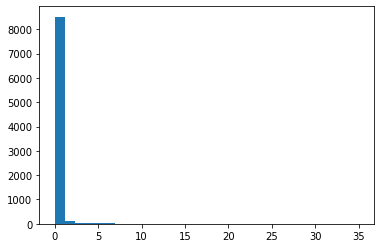

In [ ]:
plt.hist(df['Rainfall(mm)'],bins = 30)

(array([8.334e+03, 9.700e+01, 6.800e+01, 7.600e+01, 1.400e+01, 2.300e+01,
        3.000e+01, 2.400e+01, 2.500e+01, 1.000e+01, 1.000e+01, 1.900e+01,
        7.000e+00, 1.000e+01, 3.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([0.        , 0.29333333, 0.58666667, 0.88      , 1.17333333,
        1.46666667, 1.76      , 2.05333333, 2.34666667, 2.64      ,
        2.93333333, 3.22666667, 3.52      , 3.81333333, 4.10666667,
        4.4       , 4.69333333, 4.98666667, 5.28      , 5.57333333,
        5.86666667, 6.16      , 6.45333333, 6.74666667, 7.04      ,
        7.33333333, 7.62666667, 7.92      , 8.21333333, 8.50666667,
        8.8       ]),
 <a list of 30 Patch objects>)

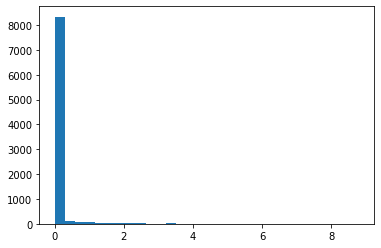

In [ ]:
plt.hist(df['Snowfall (cm)'],bins = 30)

**Select features for algorithm and split data in train and test set**


*and dropping records with Rainfall(mm) > 2 because of the outliers*

In [ ]:
df_temp = df_Hour_Cyclic[df_Hour_Cyclic.columns.difference(['Wind speed (m/s)','Snowfall (cm)'])]
#df_temp = df_Hour_Cyclic.copy()
df_temp = df_temp[df_temp['Rainfall(mm)'] < 2]
df_temp.info()
train_dataset = df_temp.sample(frac=0.8, random_state=0)
test_dataset = df_temp.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Rented Bike Count')
test_labels = test_features.pop('Rented Bike Count')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Autumn                     8610 non-null   uint8  
 1   Dew point temperature(°C)  8610 non-null   float64
 2   Functioning Day            8610 non-null   int64  
 3   Holiday                    8610 non-null   int64  
 4   Hour cos                   8610 non-null   float64
 5   Hour sin                   8610 non-null   float64
 6   Humidity(%)                8610 non-null   float64
 7   Rainfall(mm)               8610 non-null   float64
 8   Rented Bike Count          8610 non-null   float64
 9   Solar Radiation (MJ/m2)    8610 non-null   float64
 10  Spring                     8610 non-null   uint8  
 11  Summer                     8610 non-null   uint8  
 12  Temperature(°C)            8610 non-null   float64
 13  Visibility (10m)           8610 non-null   float

In [ ]:
df_temp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Autumn,8610.0,0.250058,0.433071,0.000000,0.000000,0.000000e+00,0.750000,1.000000
Dew point temperature(°C),8610.0,-0.016348,0.998890,-2.655039,-0.687142,5.560552e-02,0.806010,1.770816
Functioning Day,8610.0,0.966202,0.180719,0.000000,1.000000,1.000000e+00,1.000000,1.000000
Holiday,8610.0,0.049710,0.217357,0.000000,0.000000,0.000000e+00,0.000000,1.000000
Hour cos,8610.0,0.002312,0.999703,-1.414214,-1.000000,2.436049e-16,1.000000,1.414214
Hour sin,8610.0,-0.000997,1.000410,-1.414214,-1.000000,-6.739210e-18,1.000000,1.414214
Humidity(%),8610.0,-0.031773,0.978883,-2.859660,-0.796918,-6.022497e-02,0.725581,1.953404
Rainfall(mm),8610.0,-0.099833,0.184032,-0.131800,-0.131800,-1.317999e-01,-0.131800,1.995617
Rented Bike Count,8610.0,0.016692,0.999985,-1.092473,-0.779276,-2.831212e-01,0.571194,4.421042
Solar Radiation (MJ/m2),8610.0,0.009604,1.005844,-0.655132,-0.655132,-6.436202e-01,0.438461,3.396916


**Print Correlation Table for feature selection**

In [ ]:
df.corr(method = 'pearson')

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Autumn,Spring,Summer,Winter
Rented Bike Count,1.000000,4.102573e-01,0.538558,-0.199780,0.121108,0.199280,0.379788,0.261837,-0.123074,-0.141804,-7.233757e-02,0.203943,1.027530e-01,2.288822e-02,2.965494e-01,-4.249251e-01
Hour,0.410257,1.000000e+00,0.124114,-0.241644,0.285197,0.098753,0.003054,0.145131,0.008715,-0.021516,1.691160e-20,0.005439,2.708568e-19,1.686710e-19,1.686710e-19,-1.019481e-19
Temperature(°C),0.538558,1.241145e-01,1.000000,0.159371,-0.036252,0.034794,0.912798,0.353505,0.050282,-0.218405,-5.593084e-02,-0.050170,5.972825e-02,7.959684e-03,6.658462e-01,-7.387196e-01
Humidity(%),-0.199780,-2.416438e-01,0.159371,1.000000,-0.336683,-0.543090,0.536894,-0.461919,0.236397,0.108183,-5.027765e-02,-0.020800,2.836650e-02,1.569416e-02,1.925949e-01,-2.382952e-01
Wind speed (m/s),0.121108,2.851967e-01,-0.036252,-0.336683,1.000000,0.171507,-0.176486,0.332274,-0.019674,-0.003554,2.301677e-02,0.005037,-1.280093e-01,8.385451e-02,-6.469790e-02,1.091865e-01
Visibility (10m),0.199280,9.875348e-02,0.034794,-0.543090,0.171507,1.000000,-0.176630,0.149738,-0.167629,-0.121695,3.177281e-02,-0.026000,1.174133e-01,-1.874983e-01,6.195792e-02,8.616224e-03
Dew point temperature(°C),0.379788,3.054372e-03,0.912798,0.536894,-0.176486,-0.176630,1.000000,0.094381,0.125597,-0.150887,-6.675910e-02,-0.052837,6.287829e-02,2.055888e-03,6.523778e-01,-7.223664e-01
Solar Radiation (MJ/m2),0.261837,1.451309e-01,0.353505,-0.461919,0.332274,0.149738,0.094381,1.000000,-0.074290,-0.072301,-5.077255e-03,-0.007665,-3.137428e-02,7.997416e-02,1.284017e-01,-1.784202e-01
Rainfall(mm),-0.123074,8.714642e-03,0.050282,0.236397,-0.019674,-0.167629,0.125597,-0.074290,1.000000,0.008500,-1.426911e-02,0.002055,-1.324655e-02,1.759519e-02,5.392817e-02,-5.875456e-02
Snowfall (cm),-0.141804,-2.151645e-02,-0.218405,0.108183,-0.003554,-0.121695,-0.150887,-0.072301,0.008500,1.000000,-1.259072e-02,0.032089,-2.474218e-02,-9.978516e-02,-9.978516e-02,2.258745e-01


In [ ]:
def model_builder(hp):
  model = tf.keras.Sequential()

  hp_units_layer1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units_layer2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  model.add(layers.Dense(units=hp_units_layer1, activation='relu'))
  model.add(layers.Dense(units=hp_units_layer2, activation='relu'))
  model.add(layers.Dense(1))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=hp_learning_rate),
    loss = 'mean_squared_error'
  )
  
  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
tuner.search(train_features, train_labels, epochs=70, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 04s]
val_loss: 0.11703698337078094

Best val_loss So Far: 0.11703698337078094
Total elapsed time: 00h 01m 27s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get('units1'),best_hps.get('units2'))
print(best_hps.get('learning_rate'))

192 160
0.001


**Model Training**

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(
    train_features, train_labels, 
    epochs=100,
    verbose=1,
    validation_split = 0.2,
    callbacks=[callback]
    )

Epoch 1/100
173/173 [==============================] - 1s 3ms/step - loss: 0.4081 - val_loss: 0.1864
Epoch 2/100
173/173 [==============================] - 0s 2ms/step - loss: 0.1899 - val_loss: 0.1509
Epoch 3/100
173/173 [==============================] - 0s 2ms/step - loss: 0.1662 - val_loss: 0.1404
Epoch 4/100
173/173 [==============================] - 0s 2ms/step - loss: 0.1377 - val_loss: 0.1362
Epoch 5/100
173/173 [==============================] - 0s 2ms/step - loss: 0.1417 - val_loss: 0.1210
Epoch 6/100
173/173 [==============================] - 0s 2ms/step - loss: 0.1306 - val_loss: 0.1361
Epoch 7/100
173/173 [==============================] - 0s 2ms/step - loss: 0.1266 - val_loss: 0.1280
Epoch 8/100
173/173 [==============================] - 0s 2ms/step - loss: 0.1286 - val_loss: 0.1282
Epoch 9/100
173/173 [==============================] - 0s 2ms/step - loss: 0.1268 - val_loss: 0.1213
Epoch 10/100
173/173 [==============================] - 0s 2ms/step - loss: 0.1347 - val_lo

In [ ]:
val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 33


In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_features, train_labels, epochs=best_epoch, validation_split=0.2)

Epoch 1/33
173/173 [==============================] - 1s 3ms/step - loss: 0.4180 - val_loss: 0.1816
Epoch 2/33
173/173 [==============================] - 0s 2ms/step - loss: 0.1961 - val_loss: 0.1522
Epoch 3/33
173/173 [==============================] - 0s 2ms/step - loss: 0.1725 - val_loss: 0.1517
Epoch 4/33
173/173 [==============================] - 0s 2ms/step - loss: 0.1540 - val_loss: 0.1461
Epoch 5/33
173/173 [==============================] - 0s 2ms/step - loss: 0.1381 - val_loss: 0.1272
Epoch 6/33
173/173 [==============================] - 0s 2ms/step - loss: 0.1352 - val_loss: 0.1292
Epoch 7/33
173/173 [==============================] - 0s 2ms/step - loss: 0.1256 - val_loss: 0.1244
Epoch 8/33
173/173 [==============================] - 0s 2ms/step - loss: 0.1263 - val_loss: 0.1323
Epoch 9/33
173/173 [==============================] - 0s 2ms/step - loss: 0.1225 - val_loss: 0.1223
Epoch 10/33
173/173 [==============================] - 0s 2ms/step - loss: 0.1212 - val_loss: 0.1298

**Evaluation**

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.20])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

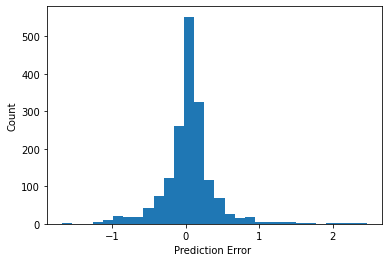

In [ ]:
test_predictions = model.predict(test_features).flatten()
error = test_predictions - test_labels

plt.hist(error, bins=30)
plt.xlabel('Prediction Error ')
_ = plt.ylabel('Count')

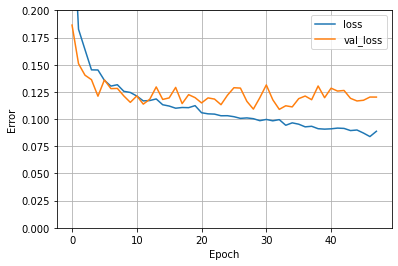

In [ ]:
plot_loss(history)

In [ ]:
error.std()

0.3533999572978382

In [ ]:
model.evaluate(test_features, test_labels, verbose=0)

0.12653511762619019

In [ ]:
from sklearn.metrics import r2_score
R2 = r2_score(test_labels, test_predictions)

In [ ]:
R2

0.8827530912218154